In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time
import random
from qiskit.aqua.components.optimizers import ADAM
import warnings
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from qulacs import QuantumCircuit
from qulacs import QuantumState
from qulacs import Observable
from qulacs import ParametricQuantumCircuit

In [ ]:
# https://dojo.qulacs.org/ja/latest/notebooks/5.2_Quantum_Circuit_Learning.html
# https://github.com/qulacs/quantum-native-dojo/blob/master/notebooks/qcl_classification.py
# の2つを参考にした

In [ ]:
# getoutputとU_inは入力次元に応じて書き換えるしかない

In [ ]:
# global変数の宣言

In [4]:
nqubit = 3
depth = 3

In [31]:
# 結果を入れるhashmap
d = {}

In [32]:
obs = Observable(nqubit)
obs.add_operator(2.,"Z 0")  # これで2 * <Z_0>を計算してくれる、グローバル変数として1つのみ作る

In [ ]:
# ここで入力データを作成

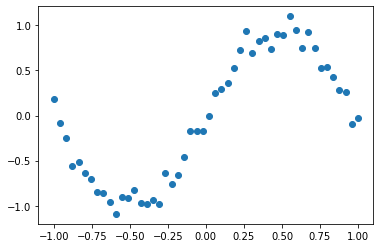

In [7]:
########  パラメータ  #############
## [x_min, x_max]のうち, ランダムにnum_x_train個の点をとって教師データとする.
x_min = - 1.; x_max = 1.;
num_x_train = 50
num_x_test = 20

## 学習したい1変数関数
func_to_learn = lambda x: np.sin(x*np.pi)
func_to_learn1 = lambda x:np.abs(x)
func_to_learn2 = lambda x:x
func_to_learn3 = lambda x:np.exp(x)
func_to_learn4 = lambda x:np.cos(np.pi*x)
func_to_learn5 = lambda x:x**2

## 乱数のシード
random_seed = 3
## 乱数発生器の初期化
np.random.seed(random_seed)
### 教師データを準備
x_train = np.linspace(-1,1,50)
y_train = func_to_learn(x_train)

# 現実のデータを用いる場合を想定し、きれいなsin関数にノイズを付加
mag_noise1 = 0.1
y_train = y_train + mag_noise1 * np.random.randn(num_x_train)

#テストデータの準備
mag_noise2 = 0.1
x_test = np.linspace(-1,1,20)
y_test = func_to_learn(x_test) + mag_noise2 * np.random.randn(num_x_test)

plt.plot(x_train, y_train, "o"); plt.show()

In [165]:
boston = datasets.load_boston()
x,y = boston.data[:200,:],boston.target[:200]  # カラム0,5、上から200データを使用する、ここは自由
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=0)

In [166]:
#これは正規化が必要な時に行う、一応やったほうが安全？
mn = MinMaxScaler(feature_range=(-1,1),copy = True)
x_train = mn.fit_transform(x_train)
x_test = mn.fit_transform(x_test)

x_train[x_train < -1] = -1
x_train[x_train > 1] = 1
x_test[x_test < -1] = -1
x_test[x_test > 1] = 1

In [8]:
numTrainData = len(x_train)

In [168]:
numdim = len(x_train[0])

In [33]:
qc_map = {}  
# x_train内のindex:対応するQuantumCircuitオブジェクト(ただしU(x)のみ保存している点がqiskitと違う)
#これはdepthやnqubitを変えるたびに初期化する
# テストデータに関しては1回ずつしか呼び出されないから特に保存しない

In [28]:
def U_in(x):    #入力xをエンコードするゲートが付いた回路（QuantumCircuit）を返す
    # 入力が1次元か多次元化に応じて少しコードを変える
    U = QuantumCircuit(nqubit)
    for i in range(nqubit):
        angle_y = np.arcsin(x)
        angle_z = np.arccos(x**2)
        U.add_RY_gate(i,angle_y)
        U.add_RZ_gate(i,angle_z)
    
    return U
# 入力次元が1の場合でもリストで渡す必要がある

In [11]:
def createInitialHEA(depth):  # ansatzに相当する部分のオブジェクトを作る、これはグローバル変数として1つのみ作る
    U = ParametricQuantumCircuit(nqubit)
    for d in range(depth):
        for i in range(nqubit):
            U.add_parametric_RY_gate(i, 2*np.pi*np.random.rand())
            U.add_parametric_RZ_gate(i, 2*np.pi*np.random.rand())
        for i in range(nqubit-1):
            U.add_CNOT_gate(i,i+1)
    return U

In [24]:
def getoutput(x,init_par):   #入力x(リスト)、出力yの予測値
    # 入力が1次元なら(x,), 多次元ならtuple(x)とする
    tupled_x = (x,)
    if tupled_x in qc_map:
        U_In = qc_map[tupled_x]
    else:
        U_In = U_in(x)
        qc_map[tupled_x] = U_In
        
    state = QuantumState(nqubit)
    state.set_zero_state()
    
    U_In.update_quantum_state(state)
    U_out.update_quantum_state(state)
    res = obs.get_expectation_value(state)
    return res

In [13]:
def cost_func_helper(x,y,par):
    y_pred = getoutput(x,par)
    return 0.5 * ((y - y_pred)**2)

In [14]:
def cost_func(par):
    res = 0
    for x,y in zip(x_train,y_train):
        res += cost_func_helper(x,y,par)
    return res

In [15]:
def gene_error(par):
    # 現在のパラメータ値がparの時のテストデータに対するコスト関数の値を返す
    res = 0
    for x,y in zip(x_test,y_test):
        res += cost_func_helper(x,y,par)
    return res

In [16]:
def deriv_func(par):
    res = []
    n = len(par)
    data = it.next()  # このデータだけを使って勾配を求める
    numdata = len(data)  # バッチサイズと同じ
    x_data = [data[i][0] for i in range(numdata)]  # data[i] = (x,y)というタプルなのでxのみ取り出す
    y_pred = [getoutput(x,par) for x in x_data]
    for i in range(n):
        temp = 0
        for j in range(numdata):
            x,y = data[j][0],data[j][1]
            temp += (y_pred[j] - y) * compute_gradient1(x,par,i)
        res.append(temp)
    res = np.array(res)
    return res

In [17]:
def compute_gradient1(x,par,i):
    par[i] += np.pi/2
    b_plus = getoutput(x,par)
    par[i] -= np.pi/2
    par[i] -= np.pi/2
    b_minus = getoutput(x,par)
    par[i] += np.pi/2
    return (b_plus - b_minus)/2

In [18]:
class Iterator:
    def __init__(self,x,y,batch_size):
        self.x = x_train   # 訓練データの入力、ndarray
        self.y = y_train   # 訓練データの出力、ddarray
        self.batch_size = batch_size  # バッチサイズ(1以上)
        self.index = 0  # データ内のどのindexを見ているかを保持する
        self.indices = list(range(len(x_train)))  # この配列を適宜シャッフルする
        
    def next(self):   # バッチサイズ分のデータをリストに入れて変えす、途中でデータを見終わったらシャッフルする
        res = []
        for _ in range(self.batch_size):
            nx = self.x[self.indices[self.index]]
            ny = self.y[self.indices[self.index]]
            res.append((nx,ny))
            self.index += 1
            if self.index == len(self.x):
                self.index = 0
                np.random.shuffle(self.indices)
        res = np.array(res)
        return res

In [ ]:
# ここから学習

In [34]:
U_out = createInitialHEA(depth)  # これもグローバルに1つのみ
parameter_count = U_out.get_parameter_count()
par = [U_out.get_parameter(i) for i in range(parameter_count)]  # これが初期パラメータ値を持ったリスト

In [35]:
adam = ADAM(maxiter = 100)
it = Iterator(x = x_train,y = y_train,batch_size = 20)

In [36]:
start = time.time()

par,mincost,_ = adam.minimize(cost_func,par,deriv_func)  # (最適パラメータ、その時のコスト関数値、イテレーション数)を返す
d[depth] = d.get(depth,[]) + [(par,mincost,gene_error(par))]  # (最適パラメータ、その時のコスト関数値、その時のテストデータに対するコスト関数値)を保存

process_time = time.time() - start

print(d[depth])
print(process_time)

[(array([0.60046401, 5.25847405, 3.35983828, 4.86926639, 1.45038703,
       6.065117  , 4.71884374, 2.15572233, 5.95977497, 4.40144532,
       5.28140106, 0.285868  , 0.34960611, 4.66675592, 1.91440132,
       3.24705193, 0.98182576, 6.14465621]), 32.80919052410563, 13.664784439956508)]
0.04285454750061035


In [ ]:
# ここから結果の解釈(結果の図示や情報量の計算を行う)

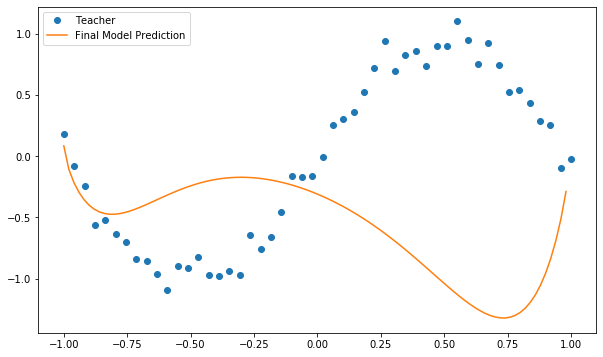

In [37]:
# プロットしたいときには以下を実行すればよい
plt.figure(figsize=(10, 6))

xlist = np.arange(x_min, x_max, 0.02)

# 教師データ
plt.plot(x_train, y_train, "o", label='Teacher')

# モデルの予測値
y_pred = np.array([getoutput(x,par) for x in xlist])
plt.plot(xlist, y_pred, label='Final Model Prediction')

plt.legend()
plt.show()